In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import math
from sklearn.metrics import mean_squared_error
import sklearn.metrics as sklm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/employee attrition/Train.csv")
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/employee attrition/Test.csv")

In [3]:
df_train.head(25)

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,33,1,1,7.0,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,36,0,3,6.0,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,51,0,2,8.0,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,56,1,3,8.0,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,62,1,3,2.0,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827
5,EID_2278,M,54.0,3,Married,Lebanon,Purchasing,Conceptual,19.0,1,21,2,5,9.0,type2,1.0,3,-1.8176,1.8688,2.0,2,8,3,0.7613
6,EID_18588,F,21.0,4,Married,Springfield,Purchasing,Directive,2.0,1,50,1,1,6.0,type2,2.0,3,-0.9612,0.7075,2.0,3,7,3,0.2819
7,EID_1235,F,NaN,3,Married,Springfield,Sales,Directive,34.0,4,23,1,4,6.0,type3,2.0,3,-0.1048,-0.4537,2.0,3,9,3,0.1169
8,EID_10197,M,40.0,4,Single,Springfield,Production,Analytical,13.0,1,49,0,1,9.0,type0,4.0,1,NaN,1.8688,2.0,5,6,3,0.1968
9,EID_21262,M,45.0,3,Married,Lebanon,IT,Directive,21.0,4,34,0,2,5.0,type3,4.0,3,0.7516,-0.4537,2.0,4,8,3,0.2870


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                7000 non-null   object 
 1   Gender                     7000 non-null   object 
 2   Age                        6588 non-null   float64
 3   Education_Level            7000 non-null   int64  
 4   Relationship_Status        7000 non-null   object 
 5   Hometown                   7000 non-null   object 
 6   Unit                       7000 non-null   object 
 7   Decision_skill_possess     7000 non-null   object 
 8   Time_of_service            6856 non-null   float64
 9   Time_since_promotion       7000 non-null   int64  
 10  growth_rate                7000 non-null   int64  
 11  Travel_Rate                7000 non-null   int64  
 12  Post_Level                 7000 non-null   int64  
 13  Pay_Scale                  6991 non-null   float

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee_ID                3000 non-null   object 
 1   Gender                     3000 non-null   object 
 2   Age                        2839 non-null   float64
 3   Education_Level            3000 non-null   int64  
 4   Relationship_Status        3000 non-null   object 
 5   Hometown                   3000 non-null   object 
 6   Unit                       3000 non-null   object 
 7   Decision_skill_possess     3000 non-null   object 
 8   Time_of_service            2948 non-null   float64
 9   Time_since_promotion       3000 non-null   int64  
 10  growth_rate                3000 non-null   int64  
 11  Travel_Rate                3000 non-null   int64  
 12  Post_Level                 3000 non-null   int64  
 13  Pay_Scale                  2997 non-null   float

In [6]:
y_train = df_train.iloc[:,23]

In [7]:
frames = [df_train,df_test]
df = pd.concat(frames, keys=['x', 'y'])

df

Employee_ID Gender   Age  ...  VAR6 VAR7 Attrition_rate
x 0      EID_23371      F  42.0  ...     5    3         0.1841
  1      EID_18000      M  24.0  ...     5    3         0.0670
  2       EID_3891      F  58.0  ...     8    3         0.0851
  3      EID_17492      F  26.0  ...     7    3         0.0668
  4      EID_22534      F  31.0  ...     8    2         0.1827
...            ...    ...   ...  ...   ...  ...            ...
y 2995   EID_22547      F  32.0  ...     7    4            NaN
  2996   EID_10066      F   NaN  ...     8    3            NaN
  2997    EID_7126      F  60.0  ...     8    4            NaN
  2998    EID_4929      F  51.0  ...     9    2            NaN
  2999   EID_24750      F  45.0  ...     8    5            NaN

[10000 rows x 24 columns]

In [8]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Attrition_rate,3000,0.3000
VAR4,954,0.0954
VAR2,794,0.0794
Age,573,0.0573
Time_of_service,196,0.0196
Work_Life_balance,16,0.0016
Pay_Scale,12,0.0012
Time_since_promotion,0,0.0000
Gender,0,0.0000
Education_Level,0,0.0000


In [9]:
df.drop('Employee_ID', axis = 1, inplace = True)
df.drop('Attrition_rate', axis = 1, inplace = True)

In [10]:
df['Work_Life_balance'].fillna(df['Work_Life_balance'].ffill(), inplace = True)
df['Pay_Scale'].fillna(df['Pay_Scale'].ffill(), inplace = True)
df['VAR2'].fillna(df['VAR2'].ffill(), inplace = True)
df['VAR4'].fillna(df['VAR4'].ffill(), inplace = True)
df['Time_of_service'].fillna(df['Time_of_service'].ffill(), inplace = True)

In [11]:
df['Age'].fillna(df['Age'].ffill(), inplace = True)

In [12]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
VAR7,0,0.0
VAR6,0,0.0
Age,0,0.0
Education_Level,0,0.0
Relationship_Status,0,0.0
Hometown,0,0.0
Unit,0,0.0
Decision_skill_possess,0,0.0
Time_of_service,0,0.0
Time_since_promotion,0,0.0


In [13]:
#df['VARf']= df['VAR2']+df['VAR3']
#df['VARi']= df["VAR1"]+df['VAR4']+df['VAR5']+df['VAR6']+df['VAR7']

In [14]:
df.describe()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.63760,3.199400,13.402300,2.37860,47.008400,0.820700,2.797000,6.022400,2.385900,3.089100,0.006968,-0.005826,1.897100,2.834800,7.110000,3.249600
std,13.56742,1.065436,10.306574,1.14978,15.848553,0.646524,1.171037,2.070296,1.128676,0.831884,0.992182,0.990812,0.532109,0.939466,1.160877,0.918795
min,19.00000,1.000000,0.000000,0.00000,20.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-1.817600,-2.776200,1.000000,1.000000,5.000000,1.000000
25%,27.00000,3.000000,5.000000,1.00000,33.000000,0.000000,2.000000,5.000000,1.000000,3.000000,-0.961200,-0.453700,2.000000,2.000000,6.000000,3.000000
50%,38.00000,3.000000,10.000000,2.00000,47.000000,1.000000,3.000000,6.000000,2.000000,3.000000,-0.104800,-0.453700,2.000000,3.000000,7.000000,3.000000
75%,52.00000,4.000000,21.000000,3.00000,61.000000,1.000000,4.000000,8.000000,3.000000,3.000000,0.751600,0.707500,2.000000,3.000000,8.000000,4.000000
max,65.00000,5.000000,43.000000,4.00000,74.000000,2.000000,5.000000,10.000000,5.000000,5.000000,1.608100,1.868800,3.000000,5.000000,9.000000,5.000000


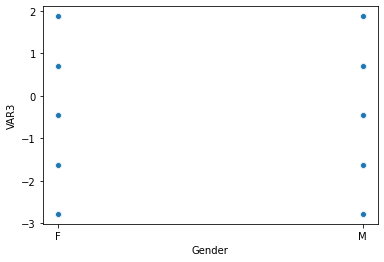

In [15]:
sns.scatterplot(x='Gender', y= 'VAR3', data=df)

In [16]:
df1 = pd.get_dummies(df, columns=list(df.select_dtypes(exclude=np.number)))
#df1 = pd.get_dummies(df1, columns =['VAR4','VAR6','VAR5','VAR7'])
df1.head()

Age  ...  Compensation_and_Benefits_type4
x 0  42.0  ...                                0
  1  24.0  ...                                0
  2  58.0  ...                                0
  3  26.0  ...                                0
  4  31.0  ...                                0

[5 rows x 46 columns]

In [17]:
X_train = df1.xs('x')
X_test = df1.xs('y')

In [18]:
from sklearn.linear_model import Lasso
import sklearn.model_selection as ms
parameters= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.004,0.005,0.01],
            'max_iter':[1,2,3,4,5,10,50,100,500,1000]
             }


lasso = Lasso()
lasso_model = ms.GridSearchCV(lasso, param_grid=parameters, cv=5)
lasso_model.fit(X_train,y_train)

print('The best value of Alpha is: ',lasso_model.best_params_)

The best value of Alpha is:  {'alpha': 0.002, 'max_iter': 2}


In [19]:
lasso_model.best_estimator_

Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=2, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [20]:
lasso_m = Lasso(alpha=0.002, copy_X=True, fit_intercept=True, max_iter=2, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
lasso_m.fit(X_train,y_train)
y_lasso_train = lasso_m.predict(X_train)
temp = math.sqrt(sklm.mean_squared_error(y_train, y_lasso_train))
score = 100*(max(0,1-temp))

In [21]:
score

81.45273636300901

In [22]:
y_lasso_test=lasso_m.predict(X_test)

In [23]:
y_lasso_test

array([0.19386236, 0.19379708, 0.17934755, ..., 0.19026021, 0.17543756,
       0.1886703 ])

In [24]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/employee attrition/Test.csv")
sample = pd.concat([test['Employee_ID'], pd.Series(y_lasso_test)], keys = ('Employee_ID', 'Attrition_rate'), axis=1)
sample

,Employee_ID,Attrition_rate
0,EID_22713,0.193862
1,EID_9658,0.193797
2,EID_22203,0.179348
3,EID_7652,0.191468
4,EID_6516,0.189232
...,...,...
2995,EID_22547,0.188294
2996,EID_10066,0.185327
2997,EID_7126,0.190260
2998,EID_4929,0.175438


In [25]:
sample.to_csv('submission_09.csv', index=False)